In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
from matplotlib import pylab
import scipy
import stft
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
%matplotlib inline

In [3]:
rate, data = wavfile.read('01-18_Pulses.wav')

In [8]:
specgram = stft.spectrogram(data[:, 1] + data[:, 0], framelength=1024)

In [9]:
log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time

In [10]:
print(log_spectrogram.shape)

(513, 28125)


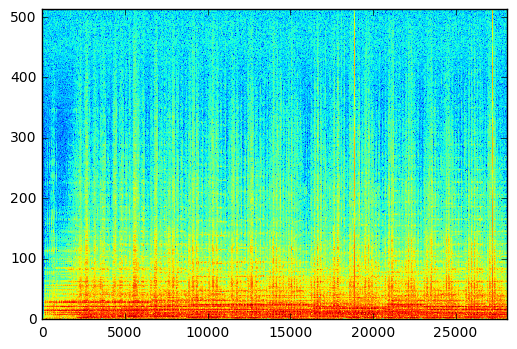

In [11]:
pylab.imshow(log_spectrogram, origin='lower', aspect='auto',
             interpolation='nearest')

In [160]:
steps = [(-1000, -1), (-500, -1), (-100, -5), (-10, -1), (-2, -1)]
min_offset = max([-(i[0]) for i in steps])
step_by_step = 75

In [161]:
min_offset

1000

In [162]:
freq_avg_step = 41
num_freq_bins_red = log_spectrogram.shape[0]//freq_avg_step
print(num_freq_bins_red)

25


In [163]:
def get_avg_amplitude(spgram_slice):
    return np.sum(spgram_slice / spgram_slice.shape[1])  # gets the average amplitude of the slice

In [164]:
def get_loudest_bin(spgram_slice):
    tmp = np.sum(spgram_slice, axis=1) / spgram_slice.shape[1]
    return np.argmax(tmp)  # returns the index of the loudest frequency bin, the slice is averaged

In [165]:
def process_frame(log_spgram, scalar_functions, n_slices, n_features):
    # features, frequency content - X, Y
    # n_slices - the number of data points
    loc_Y = np.zeros([n_slices, log_spgram.shape[0]])
    loc_X = np.zeros([n_slices, n_features])
    for i in range(n_slices):
        loc_Y[i] = log_spgram[:, min_offset + step_by_step * i]
        counter = 0
        for s_f in scalar_functions:
            for slicing in steps:
                a = min_offset + step_by_step * i + slicing[0]
                b = min_offset + step_by_step * i + slicing[1]
                loc_X[i, counter] = s_f(log_spgram[:, a:b])
                counter += 1
        for j in range(num_freq_bins_red):
            loc_X[i, counter + j] = np.sum(log_spgram[j * freq_avg_step:(j+1) * freq_avg_step, min_offset + step_by_step * i - 1])
    return [loc_X, loc_Y]

In [166]:
n_samples = 100

In [167]:
X, Y = process_frame(log_spectrogram, [get_avg_amplitude, get_loudest_bin], n_samples, 2 * len(steps) + num_freq_bins_red)

In [168]:
gen_start = min_offset + n_samples * step_by_step

In [169]:
predictors = []
for i in range(Y.shape[1]):
    if i%50 == 0:
        print(i)
    predictor = GradientBoostingRegressor()
    predictor.fit(X, Y[:, i])
    predictors.append(predictor)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [170]:
log_spectrogram.shape

(1025, 14063)

In [171]:
predictors[0].feature_importances_, predictors[1].feature_importances_

(array([ 0.02761878,  0.04335391,  0.02568   ,  0.05589791,  0.03640885,
         0.00368495,  0.02154548,  0.02271444,  0.00711623,  0.01988993,
         0.04983337,  0.01510799,  0.01868443,  0.03355787,  0.04636346,
         0.01724096,  0.01660254,  0.00457498,  0.02873213,  0.02523747,
         0.02703031,  0.01597636,  0.01750106,  0.03919767,  0.01835513,
         0.01425311,  0.01846405,  0.02773678,  0.04367761,  0.05229232,
         0.03135623,  0.02595446,  0.06599775,  0.03928879,  0.04307274]),
 array([ 0.03458978,  0.0368649 ,  0.04127838,  0.04428386,  0.06119384,
         0.03973435,  0.01248578,  0.06237501,  0.00306006,  0.02045099,
         0.02359721,  0.02492692,  0.03175786,  0.03313176,  0.02495344,
         0.00768449,  0.01531906,  0.00329612,  0.05834483,  0.01584906,
         0.07345708,  0.02978074,  0.03525655,  0.03192645,  0.00684431,
         0.01420062,  0.00561993,  0.04715128,  0.00966626,  0.01802457,
         0.02105601,  0.01173096,  0.00144813,  0

In [172]:
def create(n_samples, scalar_functions, n_features):
    res = np.zeros([min_offset + n_samples, log_spectrogram.shape[0]])
    feat_arr = np.zeros([n_samples, n_features])
    for i in range(min_offset):
        res[i, :] = log_spectrogram[:, gen_start + i]
    
    for k in range(log_spectrogram.shape[0]):
        if k%10 == 0:
            print(k)
        for i in range(n_samples):
            counter = 0
            for s_f in scalar_functions:
                for slicing in steps:
                    a = min_offset + i + slicing[0]
                    b = min_offset + i + slicing[1]
                    feat_arr[i, counter] = s_f(log_spectrogram[:, a:b])
                    counter += 1
            for j in range(num_freq_bins_red):
                feat_arr[i, counter + j] = np.sum(log_spectrogram[j * freq_avg_step:(j+1) * freq_avg_step, min_offset + i - 1])

#         print(res[min_offset + i:, k].shape)
#         print(predictors[k].predict(feat_arr).shape)
        res[min_offset:, k] = predictors[k].predict(feat_arr)
    return res[min_offset:, :]

In [173]:
newmusic = create(1000, [get_avg_amplitude, get_loudest_bin], 2 * len(steps) + num_freq_bins_red)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020


In [174]:
newmusic[newmusic<0] = 0.

In [175]:
newmusic.shape

(1000, 1025)

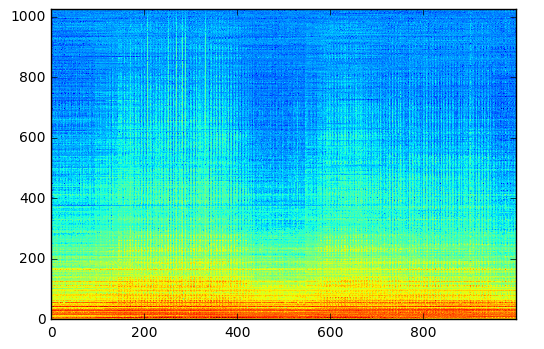

In [176]:
pylab.imshow(np.transpose(newmusic), origin='lower', aspect='auto',
             interpolation='nearest')

In [177]:
newmusic_to_write = np.exp(newmusic) - 1

In [178]:
audio_dat = stft.ispectrogram(np.transpose(newmusic_to_write), framelength=2048)

In [179]:
audio_dat.shape

(1022976,)

In [180]:
quietness = 0.00002

In [181]:
wavfile.write('reich-test2_2048.wav', 44100, audio_dat * quietness)